In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from scipy import stats
from datetime import datetime, date, timedelta
from dateutil.parser import parse
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from IPython.display import display as dsp

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

# United States Drug Prices: Forecasting and Analysis

## Abstract

We want to explore and describe the US drug market, both in terms of general trends and the price of individual drugs on the market. The purpose of this analysis is to explore what features impact how and why drug prices change, to create a reliable metric for market volatility, and to analyse and forecast trends in drug prices. As a part of this analysis, we have explored the relationship between generic and branded drugs and their prices, net market price, percent change and date. We then used Auto Regressive and Moving Averages modeling to perform more detailed time series analysis and forecasting of both our market volatility metric and the individual drug prices.

## Data Collection

The dataset we will be performing this analysis on is the [NADAC Comparison Dataset](https://data.medicaid.gov/Drug-Pricing-and-Payment/NADAC-Comparison). The NADAC Comparison Dataset is the log of every drug price change submitted to the National Drug Acquisition Cost database. We have a record of every FDA approved drug price change to work with.

To access this data, we will be using an API to pull the dataset directly from the website. The API has some SoQL functionality implemented, we are capable of selecting the number of entires that we want to pull from the date of 11/28/2013

In [2]:
#Socrata SQL query
SODA = '$limit=500000'
URL = 'https://data.medicaid.gov/resource/444w-ftrz.csv?{}'.format(SODA)

TRAIN_SPLIT = 0.8

In [3]:
def list_unique_counts(df):
    column_name, unique_values_count, datatype = [], [], []
    results = pd.DataFrame()
    for col in df.columns:
        #print(col, '\t\t\t', len(df[str(col)].unique()))
        column_name.append(col)
        unique_values_count.append(len(df[str(col)].unique()))
        datatype.append(df[str(col)].dtype)
    
    results['Column_Name'] = column_name
    results['Unique_Value_Count'] = unique_values_count
    results['Data_Type'] = datatype
    
    dsp(results)
    print('Total Number of Changes: {}'.format(df.shape[0]))
    
    print('Total Number Observations: ', df.shape[0])

def train_split(df, TRAIN_SPLIT):
    split_point = int(len(df) * (TRAIN_SPLIT))
    train = df[:split_point]
    test = df[split_point:]
    return train, test

def strip_time(date):
    date = date.replace('T00:00:00.000', '')
    return datetime.strptime(date, '%Y-%m-%d')

def return_name(ndc_description):
    if len(ndc_description) == 0:
        return '','','',''
    drug_name, dosage, dosage_unit, drug_form = [], np.nan, np.nan, np.nan
    
    #Check and see if we are dealing with concentration
    concentration = False
    if set('%') <= set(ndc_description):
        concentration = True
        ndc_description.replace('%', '')
    
    #Create our array of words
    words = ndc_description.split()
    
    for i in range(len(words)):
        if not words[i].replace('.','').replace('%', '').isnumeric():
            drug_name.append(words[i])
            
        if words[i].replace('.','').replace('%','').isnumeric():
            dosage = float(words[i].replace('%', ''))
            
            if not concentration:
                try:
                    dosage_unit = words[i + 1]
                    drug_form = ' '.join(words[i + 2:])
                except:
                    drug_form = ' '.join(words[i:])
                    #print(ndc_description, concentration)
                break
            
            if concentration:
                dosage_unit = 'concentration'
                drug_form = ' '.join(words[i + 1:])
                break
            
    drug_name = ' '.join(drug_name)
    return pd.Series([drug_name, dosage, dosage_unit, drug_form])

def drop_na_printout(dataframe):
    i = dataframe.shape[0]
    j = dataframe.dropna().shape[0]
    
    percent_loss = (i - j) / i * 100
    
    print(percent_loss, '% data lost in cleaning.')
    
    return dataframe.dropna()

def ts_lin_test(series):
     return stats.linregress(range(len(series)), series.values)

### Data Description

The data herein contains price changes applied to the database. Each observation contains an 'ndc_description' string, which encapsulate the drug name, the dosage (including units of measurement) and the drug format. The 'ndc' column contains a serial particular to the label, product and package. The 'old_nadac_per_unit' and 'new_nadac_per_unit' describe the USD price listed per unit. 

The 'classification_for_rate_setting' tells us if the drug whose rate is being changed is labeled as generic or branded. The 'percent_change' gives us the percent change from the old to new price. The 'primary_reason' gives us the reason listed for the change and the 'start_date' tells us when the change is applied to the database.

### Data Cleaning and Preparation

Our most intensive issue at this point is the extraction of the drug name and dosage information from the ndc description. To perform a more comprehensive analysis, we will need to scale the price to the dosage of the drug. Not every ndc description follows the same format of drug name + dosage measure + units of measurement + format. A few drugs do not even include dosage measures and units of measurements, so we can expect some data loss at this point. We are able to extract information from drugs sold as a solution and in a solid form.

In [4]:
raw = pd.read_csv(URL, parse_dates = True)

#Convert dates to date format
raw['start_date'] = raw['start_date'].apply(lambda x: strip_time(x))
raw['end_date'] = raw['end_date'].apply(lambda x: strip_time(x))

#Remove Effective Date
raw = raw.drop('effective_date', 1)

In [10]:
print(raw.columns)

#Create 'days_effective' and 'day_count' columns
raw['days_effective'] = (raw['end_date'] - raw['start_date'])
raw['days_effective'] = raw['days_effective'].apply(lambda x: x.days)

raw['days_count'] = (raw['start_date'] - min(raw['start_date']))
raw['days_count'] = raw['days_count'].apply(lambda x: x.days)

#Create price change column
raw['price_change'] = raw['new_nadac_per_unit'] - raw['old_nadac_per_unit']

#Create 'month-year' column because most changes happen in the middle of every month
raw['year-month'] = raw['start_date'].apply(lambda x: x.strftime('%Y-%m'))

#Add drug name column, we want to ignore dosage and format
raw[['drug_name', 'dosage','dosage_unit','drug_form']] = \
raw['ndc_description'].apply(lambda x: return_name(x))

#Remove all first-date entries
if len(raw['start_date'].unique()) > 1:
    raw.drop(raw[raw['start_date'] == min(raw['start_date'])].index, inplace = True)

#Remove last month of data, this is typically truncated by the limitations of our API call
if len(raw['year-month']) > 3:
    raw.drop(raw[raw['year-month'] == max(raw['year-month'])].index, inplace = True)

Index(['ndc_description', 'ndc', 'old_nadac_per_unit', 'new_nadac_per_unit',
       'classification_for_rate_setting', 'percent_change', 'primary_reason',
       'start_date', 'end_date', 'days_effective', 'days_count',
       'price_change', 'drug_name', 'dosage', 'dosage_unit', 'drug_form'],
      dtype='object')


In [11]:
#Generate change_count df
change_count = raw[['ndc', 'start_date']].groupby('start_date').count()
print('Our data represents the range of dates between {} and {}'.format(change_count.index.min().strftime('%Y-%m-%d'),
                                                                        change_count.index.max().strftime('%Y-%m-%d')))

Our data represents the range of dates between 2013-12-11 and 2015-12-30


In [12]:
#Remove observations with missing entries.
raw = drop_na_printout(raw)

13.085106382978722 % data lost in cleaning.


In [13]:
#Scale price to dosage
raw['daily_max_dosage'] = raw.groupby(['drug_name', 'start_date', 'dosage_unit'])['dosage'].transform('max')
raw['scaled_old_per_unit'] = raw['daily_max_dosage'] / raw['dosage'] * raw['old_nadac_per_unit']
raw['scaled_new_per_unit'] = raw['daily_max_dosage'] / raw['dosage'] * raw['new_nadac_per_unit']
raw['scaled_percent_change'] = (raw['scaled_new_per_unit'] - raw['scaled_old_per_unit']) \
/ raw['scaled_old_per_unit'] * 100

In [14]:
#Create drugs dataframe
drugs = raw[['drug_name','old_nadac_per_unit','new_nadac_per_unit']].groupby(['drug_name']).mean().rename(
    {'old_nadac_per_unit' : 'old_average_per_unit','new_nadac_per_unit': 'new_average_per_unit'}, axis = 1)
drugs['percent_average_change'] = (drugs['new_average_per_unit'] 
                                   - drugs['old_average_per_unit']) / drugs['new_average_per_unit'] * 100

In [15]:
max_price, min_price, max_dosage = [], [], []
for drug in drugs.index:
    max_price.append(max(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    min_price.append(min(raw[raw['drug_name'] == drug]['new_nadac_per_unit']))
    max_dosage.append(max(raw[raw['drug_name'] == drug]['dosage']))
drugs['max_per_unit'] = max_price
drugs['min_per_unit'] = min_price
drugs['max_dosage'] = max_dosage
drugs.head()

,old_average_per_unit,new_average_per_unit,percent_average_change,max_per_unit,min_per_unit,max_dosage
drug_name,,,,,,
,0.061608,0.061494,-0.185384,0.06650,0.05932,8.0
12-HR DECONGEST,0.341570,0.342896,0.386823,0.37681,0.32264,120.0
ABACAVIR,4.303600,4.246232,-1.351048,6.13318,3.09071,300.0
ABILIFY,28.790676,30.332430,5.082858,40.98323,5.50154,30.0
ABILIFY DISCMELT,30.165025,34.659615,12.967801,35.01615,34.30308,15.0


## Exploratory Data Analysis

### Metadata

The first order of business with our data is to discern what datatype and how many unique entries are present in our raw dataset.

In [16]:
print('\nUnique Values in Raw Data per Column:')
list_unique_counts(raw)


Unique Values in Raw Data per Column:


,Column_Name,Unique_Value_Count,Data_Type
0,ndc_description,4786,object
1,ndc,41872,object
2,old_nadac_per_unit,49291,float64
3,new_nadac_per_unit,49332,float64
4,classification_for_rate_setting,2,object
5,percent_change,6078,float64
6,primary_reason,4,object
7,start_date,106,datetime64[ns]
8,end_date,106,datetime64[ns]
9,days_effective,1,int64


Total Number of Changes: 416670
Total Number Observations:  416670


Of interest are two observations:

First, the days effective, which describes how many days are between the 'start date' and the 'end date'. There are only two unique values listed in this column, 6 and 7. As the database updates on a weekly basis, this makes sense. We will be using the start date for our time series analysis.

Second, there are an overwhelming numnber of ndc values as there are drug names, or even ndc descriptions. The ndc code represents specific batches and labels, which is information we are unable to take into account. It is far more useful to group by drug name or ndc description.

In [17]:
print('Top value counts for NDC:')
dsp(raw['ndc'].value_counts().sort_values(ascending = False).head())

print('\nTop value counts for NDC description:')
dsp(raw['ndc_description'].value_counts().sort_values(ascending = False).head())

print('\nTop value counts for drug name:')
dsp(raw['drug_name'].value_counts().sort_values(ascending = False).head())

Top value counts for NDC:


378542401    22
54458127     22
555009796    22
93423410     22
378800801    22
Name: ndc, dtype: int64


Top value counts for NDC description:


METFORMIN HCL 500 MG TABLET      1976
LISINOPRIL 20 MG TABLET          1628
LISINOPRIL 10 MG TABLET          1567
AMLODIPINE BESYLATE 5 MG TAB     1551
AMLODIPINE BESYLATE 10 MG TAB    1508
Name: ndc_description, dtype: int64


Top value counts for drug name:


LISINOPRIL             7477
RISPERIDONE            5452
GABAPENTIN             4683
SIMVASTATIN            4319
AMLODIPINE BESYLATE    4203
Name: drug_name, dtype: int64

Here we can see the number of entries per ndc code and ndc description. The specificity of the ndc code means for the intent of our analysis, this can be ignored. The ndc description list also has an issue. Depeding on the number of unique dosages, drug names will be repeated multiple times. Since we are interested in individual drugs, we must consolidate this information into the drug name.

### Data Distribution

We create two dataframes, the first which contain columns from the raw dataset we are interested in for further analysis. The second with all numeric data remove. As we may also be interested in exploring outliers later.

In [18]:
data = raw[['drug_name','start_date', 'days_count', 'year-month', 'old_nadac_per_unit', 'new_nadac_per_unit', \
            'price_change','scaled_old_per_unit', 'scaled_new_per_unit', 'percent_change', 'scaled_percent_change']]

#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_out_rm = data[(np.abs(stats.zscore(data[['percent_change']])) < 3).all(axis = 1)]

#### Percent Change

Percent change is a good metric for understanding how volatile individual drugs are, as it is a ratio measurement of change. However, it is not a good indicater to use when comparing drugs to other drugs as there is no indication of magnitude of price. For example, if a drug were to increase from 0.01 USD to 0.02 USD, we would see a notable 50% increase, within the drug history, but the price itself would not be noteworthy when comparing a drug that changed from 100 USD to 200 USD per unit.

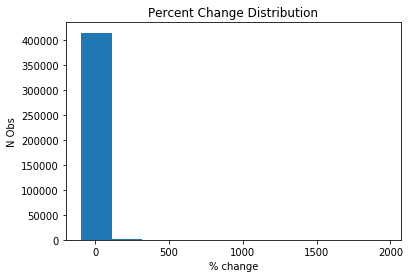

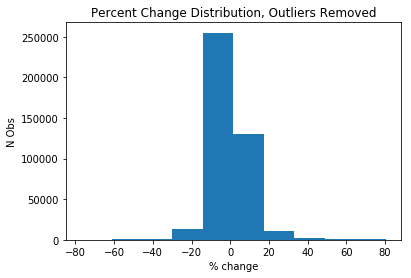

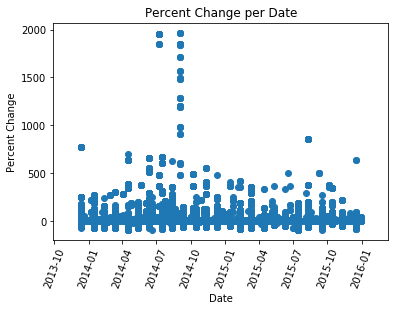

In [19]:
plt.title('Percent Change Distribution')
plt.hist(data['percent_change'])
plt.xlabel('% change')
plt.ylabel('N Obs')
plt.show()

plt.title('Percent Change Distribution, Outliers Removed')
plt.hist(data_out_rm['percent_change'])
plt.xlabel('% change')
plt.ylabel('N Obs')
plt.show()

plt.title('Percent Change per Date')
plt.scatter(data['start_date'], data['percent_change'])
plt.xticks(rotation = 70)
plt.xlabel('Date')
plt.ylabel('Percent Change')

plt.show()

In [20]:
raw.groupby(['drug_name']).max().sort_values('percent_change', ascending = False)['percent_change'][:10]

drug_name
CLOBETASOL              1966.75
AMITRIPTYLINE HCL       1950.62
CORMAX                  1203.89
CLOBETASOL EMOLLIENT     913.55
NAPROXEN SODIUM          857.48
DIGOXIN                  779.27
DIGOX                    779.27
FLUOROMETHOLONE          698.46
HYDROCORTISONE           637.50
BACLOFEN                 636.40
Name: percent_change, dtype: float64

#### Price per Unit: de facto and scaled

On the surface, even with outliers removed, it is clear that the distribution of prices per unit over the entire log is a steep exponential distribution. This shows that there are lots of drug changes where the final price of the drug change is fairly small. Our suspicions are confirmed when we group our data by average price per drug name. We are using the scaled price when observing this distribution as having multiple denominations of drugs may introduce scaling issues that prevent our data from fully reflecting the reality of the data.

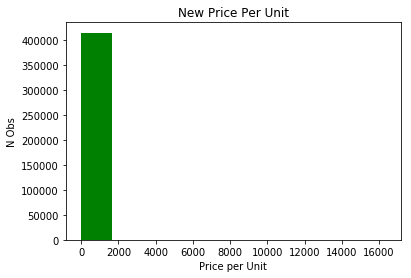

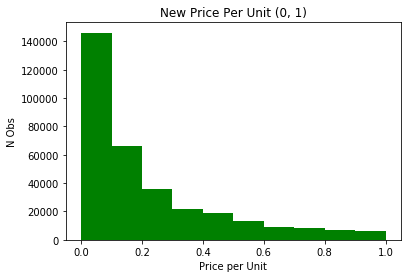

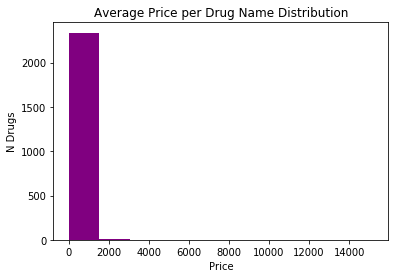

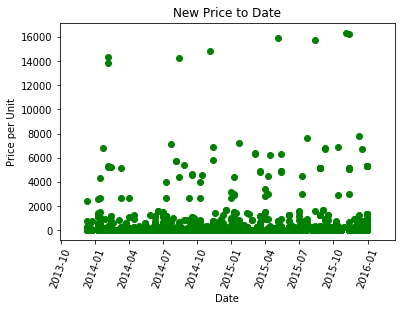

In [21]:
plt.title('New Price Per Unit')
plt.hist(data_out_rm['new_nadac_per_unit'], color = 'green')
plt.xlabel('Price per Unit')
plt.ylabel('N Obs')
plt.show()

plt.title('New Price Per Unit (0, 1)')
plt.hist(data['new_nadac_per_unit'], range = (0, 1), color = 'green')
plt.xlabel('Price per Unit')
plt.ylabel('N Obs')
plt.show()

drugmean = data.groupby(['drug_name']).mean()[['new_nadac_per_unit', 'scaled_new_per_unit']]
plt.title('Average Price per Drug Name Distribution')
plt.hist(drugmean['scaled_new_per_unit'], color = 'purple')
plt.xlabel('Price')
plt.ylabel('N Drugs')
plt.show()

plt.title('New Price to Date')
plt.scatter(data['start_date'], data['new_nadac_per_unit'], color = 'green')
plt.xticks(rotation = 70)
plt.xlabel('Date')
plt.ylabel('Price per Unit')
plt.show()

#Price Differential
#Remove Outliers

There appears to be some form of seasonality in the scatterplot for the price per unit data which does not appear to be reflected in the percent change scatterplot. This implies that the outliers here are indicitive of a single drug whose value is changed on a monthly or near monthly basis.

When we compare the new nadac per unit to the scaled new nadac per unit, we can see that we have slightly altered the distribution. Our distribution has become marginally less sharp. This is a direct result of how we performed the scaling, where we scaled the drug price to the highest dosage, multiplying lower dosages by a scaling factor to raise the price to reflect the amount of active ingredient included.

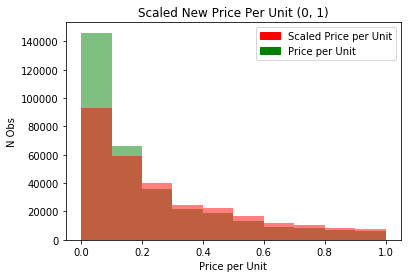

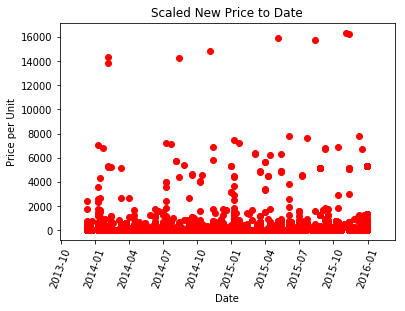

In [22]:
plt.title('Scaled New Price Per Unit (0, 1)')
plt.hist(data['new_nadac_per_unit'], range = (0, 1), color = 'green', alpha = 0.5)
plt.hist(data['scaled_new_per_unit'], range = (0, 1), color = 'red', alpha = 0.5)
red_patch = mpatches.Patch(color='red', label='Scaled Price per Unit')
green_patch = mpatches.Patch(color='green', label='Price per Unit')
plt.legend(handles = [red_patch, green_patch])
plt.xlabel('Price per Unit')
plt.ylabel('N Obs')
plt.show()

plt.title('Scaled New Price to Date')
plt.scatter(data['start_date'], data['scaled_new_per_unit'], color = 'red')
plt.xticks(rotation = 70)
plt.xlabel('Date')
plt.ylabel('Price per Unit')
plt.show()

#Overlap Scaled and raw
#Don't hard code the range

#### Price Change

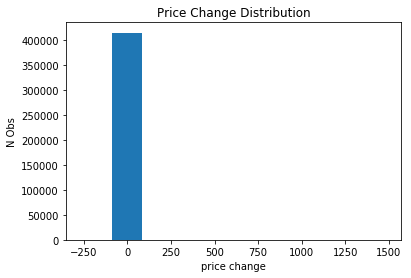

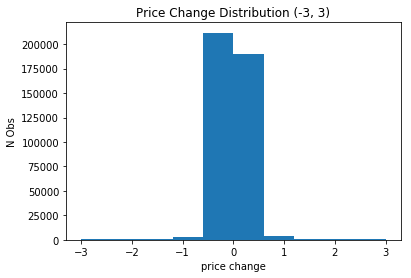

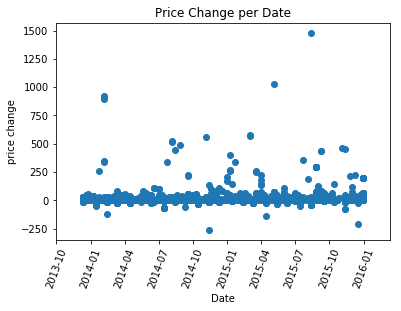

In [23]:
plt.title('Price Change Distribution')
plt.hist(data_out_rm['price_change'])
plt.xlabel('price change')
plt.ylabel('N Obs')
plt.show()

plt.title('Price Change Distribution (-3, 3)')
plt.hist(data_out_rm['price_change'], range = (-3, 3))
plt.xlabel('price change')
plt.ylabel('N Obs')
plt.show()

plt.title('Price Change per Date')
plt.scatter(data['start_date'], data['price_change'])
plt.xticks(rotation = 70)
plt.xlabel('Date')
plt.ylabel('price change')

plt.show()

The price change reflects the price differential between old and new price. This metric is more useful for comparing magnitude of changes between drugs rather than performance within drugs themselves. We may further improve the comparison by introducing a percentage factor. A high percentage with a high price differential implies prominence to the change as this implies a cheap drug becoming more expensive.

In [24]:
print('\nTop drug name max price changes:')
dsp(raw.groupby(['drug_name']).max().sort_values('price_change', ascending = False)['price_change'].head())


Top drug name max price changes:


drug_name
STELARA            1480.59400
SIMPONI             577.98378
COPAXONE            485.82069
SANDOSTATIN LAR     397.58012
NEULASTA            355.24168
Name: price_change, dtype: float64

#### Correlation Testing

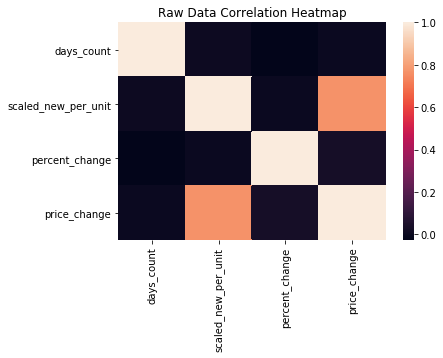

In [25]:
sns.heatmap(data[['days_count', 'scaled_new_per_unit', 'percent_change', 'price_change']].corr())
plt.title('Raw Data Correlation Heatmap')
plt.show()

Here we have our correlation matrix between some of our features of interest. Some points of interest here:

1. We can infer that the number of days since the start and the percent change are strongly uncorrelated between individual observations. This implies that the percent change does not notably change with time.

2. We can see that the price change and the scaled new price per unit are fairly well correlated, whereas the percent change is not. From this we can infer that the price of the drug is not a factor in the percent change of the drug.

Naturally, this correlation map is a good indicator of correlating features within individual observations, but terrible at describing general trends within the data. There is the issue of sampling, the observations submitted on a day with fewer observations will be more heavily weighted than on a day with many observations when it comes to correlations with time.

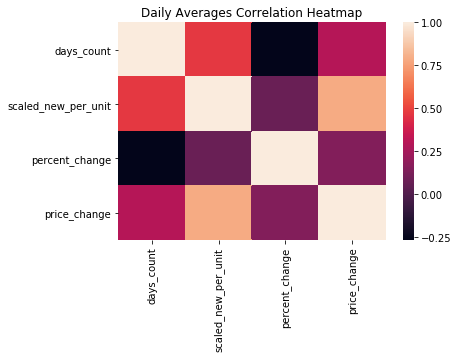

In [26]:
sns.heatmap(data.groupby('year-month').mean()\
            [['days_count','scaled_new_per_unit', 'percent_change', 'price_change']].corr())

plt.title('Daily Averages Correlation Heatmap')
plt.show()

Price = A * e ^ f(percent)

df / dt < 0
dPrice / dt > 0

Here, we have grouped our data by month, and we can already see a greater spectrum of correlation. Again, we can note that the percent change is negatively correlated with the day count, but the price change is. This, combined with the correlation between day count and price per unit, is indicative of slowing exponential growth in the drug prices as every month drug prices increase by some diminishing percentage.

#### Generic VS Branded

96.8% of changes are to generic medicines.


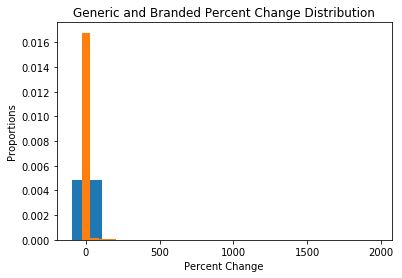

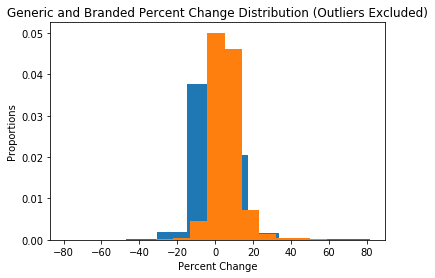

Mean Percent Change for Generic Drugs: 1.21 percentage points
Mean Percent Change for Branded Drugs: 6.24 percentage points
Standad Deviation for Generic Drugs: 26.83 percentage points
Standad Deviation for Branded Drugs: 17.68 percentage points
T-Statistic: -21.0
P-Value: 0.0


In [27]:
print('{}% of changes are to generic medicines.'.format(round(len(raw[raw['classification_for_rate_setting'] == 'G'])
                                                              / raw.shape[0], 3) * 100))
raw_generic = raw[raw['classification_for_rate_setting'] == 'G']['percent_change']
raw_branded = raw[raw['classification_for_rate_setting'] == 'B']['percent_change']

#Compare how often and the magnitude of change between generic and branded medicine.
plt.title('Generic and Branded Percent Change Distribution')
plt.hist(raw_generic, normed = True)
plt.hist(raw_branded, normed = True)

plt.xlabel('Percent Change')
plt.ylabel('Proportions')
plt.show()


plt.title('Generic and Branded Percent Change Distribution (Outliers Excluded)')
plt.hist(raw_generic[(np.abs(stats.zscore(raw_generic)) < 3)], normed = True)
plt.hist(raw_branded[(np.abs(stats.zscore(raw_branded)) < 3)], normed = True)

plt.xlabel('Percent Change')
plt.ylabel('Proportions')
plt.show()

#Print Stats
print('Mean Percent Change for Generic Drugs: {} percentage points'.format(round(raw_generic.mean() ,2)))
print('Mean Percent Change for Branded Drugs: {} percentage points'.format(round(raw_branded.mean() ,2)))

print('Standad Deviation for Generic Drugs: {} percentage points'.format(round(raw_generic.std() ,2)))
print('Standad Deviation for Branded Drugs: {} percentage points'.format(round(raw_branded.std() ,2)))

#T-test
t_stat, p_val = stats.ttest_ind(raw_generic, raw_branded)

print('T-Statistic: {}'.format(round(t_stat)))
print('P-Value: {}'.format(round(p_val)))


### Metrics for General Volatility

What do we mean by volatility?

Volatility is a measure of a system's proclivity to change. We want to create a metric that best describes the volatility of drug prices in the US. The changelog format of our dataset lends it well to exploring various measures of volatility.

#### Changes per Day

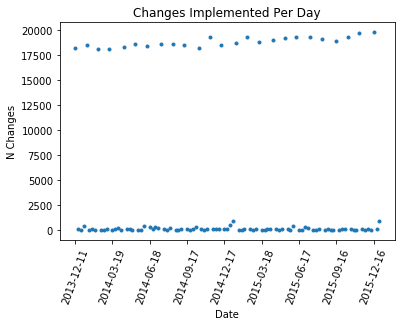

In [28]:
plt.title('Changes Implemented Per Day')
plt.plot(change_count.index.strftime('%Y-%m-%d'), change_count.values, '.')
plt.xticks(np.arange(0,len(change_count.index), round((len(change_count.index)) / 8)), rotation = 70)
plt.xlabel('Date')
plt.ylabel('N Changes')
plt.show()

There are two glaring issues to note with using the total number of changes per day as a metric for market volatility. First, our database updates once a week, so the highest resolution we can get from the data is by week. Second, the vast majority of changes are submitted every four weeks. There may be something of interest in comparing the metrics of changes submitted on low volume days vs high volume days, but this is beyond the scope of this analysis. For now, we will look at the data at a montly resolution.

#### Changes per Month

On the surface, changelog entry counts make sense as a metric for market volatility. The more changes that are submitted, the more the market changes. This encapsulates new drugs entering the market and major drug pricing policy changes.

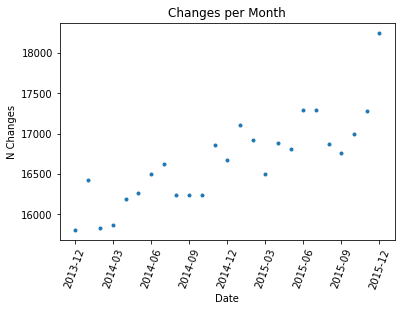

LinregressResult(slope=62.979230769230746, intercept=15911.049230769231, rvalue=0.838306746823321, pvalue=1.6851357513049148e-07, stderr=8.540541599359717)

In [29]:
mnth_count = raw['year-month'].value_counts().sort_index()
plt.title('Changes per Month')
plt.plot(mnth_count, '.')
plt.xticks(np.arange(0,len(mnth_count.index), round((len(mnth_count.index)) / 8)), rotation = 70)
plt.xlabel('Date')
plt.ylabel('N Changes')
plt.show()

#Linearity test
#slope, intercept, r_value, p_value, std_err = 
stats.linregress(range(len(mnth_count)), mnth_count.values)

We can clearly see a linear trend within the data here, with a fairly high r-value. This data would be good to use in a model as a result of its linearity. Conceptually, using gross number of changes per period also makes sense, as a period with a higher number of changes could be considered more 'volatile'.

#### Average Percent Change per Month

We can also measure volatility by looking at the average percent change per month. This gives us an indication as to how much each drug is changing in comparison to itself. This is a good metric for taking into account the magnitude rate of change.

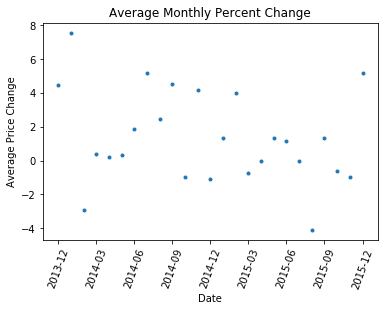

LinregressResult(slope=-0.10153629983797113, intercept=2.5844875205825817, rvalue=-0.2700824730767621, pvalue=0.19165471076540913, stderr=0.07547686806882559)

In [30]:
mnth_avgs = raw.groupby(['year-month']).mean()
plt.title('Average Monthly Percent Change')
plt.plot(mnth_avgs['percent_change'], '.')
plt.xticks(np.arange(0,len(mnth_avgs.index), round((len(mnth_avgs.index)) / 8)), rotation = 70)
plt.xlabel('Date')
plt.ylabel('Average Price Change')
plt.show()

stats.linregress(range(len(mnth_avgs['percent_change'])), mnth_avgs['percent_change'].values)

Our linear regression test shows the negative correlation we had observed before, but the linearity is fairly poor.

Text(0, 0.5, 'Observations')

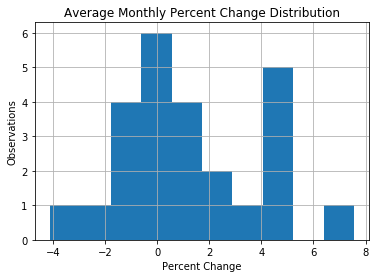

In [31]:
plt.title('Average Monthly Percent Change Distribution')
mnth_avgs['percent_change'].hist()
plt.xlabel('Percent Change')
plt.ylabel('Observations')

#### Total Price Gain/Loss per Month

Another potential metric for market volatility we may use is the total price gain/loss per month. Essentially, we take the sum of every entry in the changelog per month as our metric. This is a direct measure of price, but is more sensitive to individual drugs with many different dosages being changed.

In [32]:
raw['total_price_change'] = raw['new_nadac_per_unit'] - raw['old_nadac_per_unit']
mnth_sum = raw.groupby(['year-month']).sum()

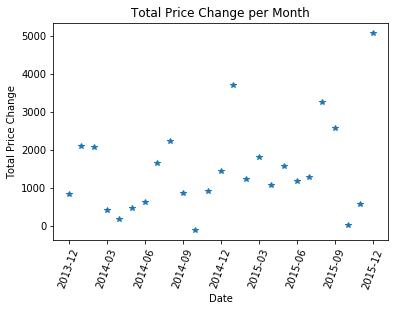

LinregressResult(slope=53.75109712307836, intercept=839.8224417230575, rvalue=0.3265654178783735, pvalue=0.11109977731402178, stderr=32.43883625889606)

In [33]:
plt.title('Total Price Change per Month')
plt.plot(mnth_sum['total_price_change'], '*')
plt.xticks(np.arange(0,len(mnth_sum.index), round((len(mnth_sum.index)) / 8)), rotation = 70)
plt.xlabel('Date')
plt.ylabel('Total Price Change')
plt.show()
stats.linregress(range(len(mnth_sum['total_price_change'])), mnth_sum['total_price_change'].values)

We can see positive trends in the data, however, the linearity is still fairly low.

Unfortunately, limited by our dataset, we do not have a complete picture of the supply and demand for drugs in the US. For that, we would need to introduce data which included information regarding how many units of every drug are purchased. However, we can infer some information regarding the volatility with any of the data above. To that end I will be using the total count log as my metric of volatility.

### Preliminary ARIMA modeling

Auto Regression and Moving Averages is an ideal model to use with this data. ARIMA modeling is exceptional at working with time series data as it is exceptional at picking up longer term linear trends (AR) and short term/seasonal events (MA). Lets look at how well ARIMA modeling works with our data.

In [34]:
#Calculate the correlation within these and their respective p-values
count_arima = ARIMA(mnth_count, order=(0,1,1)) #Play around with the order (110 101)
p_chng_arima = ARIMA(mnth_avgs['percent_change'], order=(1,0,1))
tot_chng = ARIMA(mnth_sum['total_price_change'], order=(1,0,1))

count_arima_fit = count_arima.fit()
p_chng_arima_fit = p_chng_arima.fit()
tot_chng_fit = tot_chng.fit()

print(count_arima_fit.summary())
print('\n\n\n')
print(p_chng_arima_fit.summary())
print('\n\n\n')
print(tot_chng_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.year-month   No. Observations:                   24
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -172.670
Method:                       css-mle   S.D. of innovations            301.450
Date:                Sun, 15 Sep 2019   AIC                            351.341
Time:                        01:24:15   BIC                            354.875
Sample:                    01-01-2014   HQIC                           352.279
                         - 12-01-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 62.9793      8.361      7.533      0.000      46.593      79.366
ma.L1.D.year-month    -1.0000      0.114     -8.758      0.000      -1.224      -0.776
                    

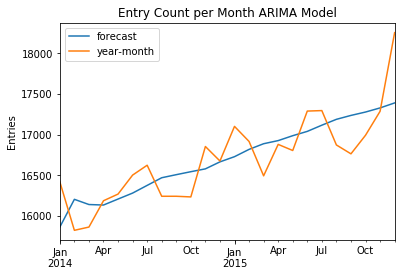

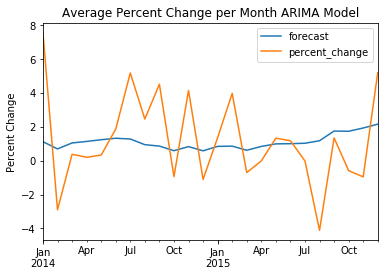

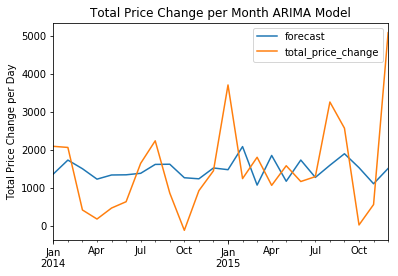

In [35]:

count_arima_fit.plot_predict(start = mnth_count.index[1],end = max(mnth_count.index))
plt.title('Entry Count per Month ARIMA Model')
plt.ylabel('Entries')

p_chng_arima_fit.plot_predict(start = mnth_avgs.index[1],end = max(mnth_avgs.index))
plt.title('Average Percent Change per Month ARIMA Model')
plt.ylabel('Percent Change')

tot_chng_fit.plot_predict(start = mnth_sum.index[1],end = max(mnth_sum.index))
plt.title('Total Price Change per Month ARIMA Model')
plt.ylabel('Total Price Change per Day')
plt.show()

Unfortunately, our chosen metric for 

### Model Performance

We can evaluate model performance by observing the plot and histogram of the residuals, that is the difference at every point between observed and predicted values for our measure at every available point in time. Ideally, the residuals scatter plot would show no correlation between day and magnitude, and that the histogram for the residuals would show a normal distribution

Text(0.5, 1.0, 'Histogram of Total Change Residuals')

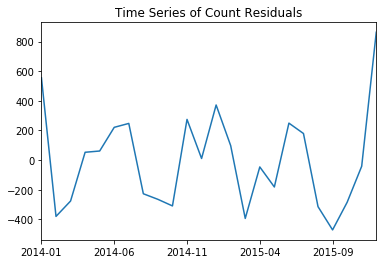

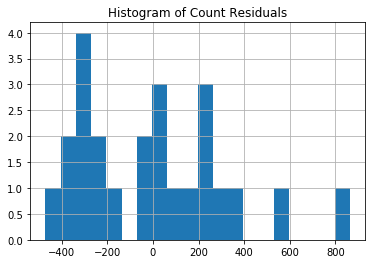

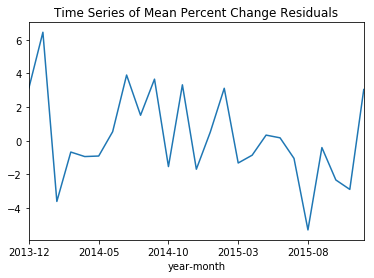

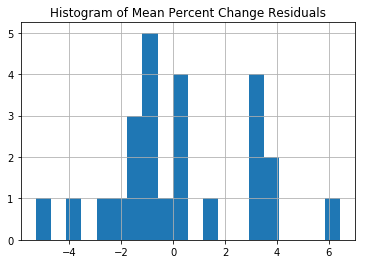

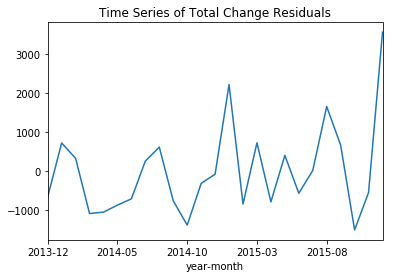

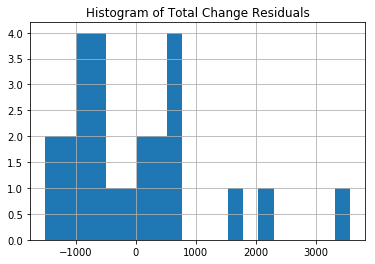

In [36]:
residuals_count = pd.DataFrame(count_arima_fit.resid)
residuals_count.plot(legend=False)
plt.title('Time Series of Count Residuals')
residuals_count.hist(bins=20)
plt.title('Histogram of Count Residuals')

residuals_p_chng = pd.DataFrame(p_chng_arima_fit.resid)
residuals_p_chng.plot(legend=False)
plt.title('Time Series of Mean Percent Change Residuals')
residuals_p_chng.hist(bins=20)
plt.title('Histogram of Mean Percent Change Residuals')

residuals_tot_chng = pd.DataFrame(tot_chng_fit.resid)
residuals_tot_chng.plot(legend=False)
plt.title('Time Series of Total Change Residuals')
residuals_tot_chng.hist(bins=20)
plt.title('Histogram of Total Change Residuals')

Unfortunately, in terms of monthly data, we do not have very many datapoints to fill out our histogram. We can still use these models to make decent predictions with the resolution we have.

It appears that the ARIMA model when applied to the total monthly entry counts performs best. The distribution is begining to look normal and the residuals do not appear to have much of a correlation. We may increase the number of datapoints at a later time; however, the best approach to doing so would be to use some form of distributed computing methodology given the sheer size of the entire database.

#### Drug Name: Record Count and Price Change

Before we move on to forecasting, lets look at the correlation between features specific to trends within individual drugs. We want to know how the record counts, the average percent change and the price correlate with one another between individual drugs. This may offer us some clues as to what features would best be used to predict the prices of our drugs.

In [37]:
#Create a dataframe for every drug name
drugs = pd.DataFrame(index = raw['drug_name'].unique())

drugs['value_counts'] = raw.groupby(['drug_name']).count()['ndc']
drugs['average_price_per_unit'] = raw.groupby(['drug_name']).mean()['new_nadac_per_unit']
drugs['average_scaled_price_per_unit'] = raw.groupby(['drug_name']).mean()['scaled_new_per_unit']
drugs['average_percent_change'] = raw.groupby(['drug_name']).mean()['percent_change']

drugs.head()

,value_counts,average_price_per_unit,average_scaled_price_per_unit,average_percent_change
12-HR DECONGEST,100,0.342896,0.342896,0.425200
,50,0.061494,0.061494,-0.139600
ABACAVIR,185,4.246232,4.246232,-0.905189
ACAMPROSATE CALC DR,85,0.788718,0.788718,0.331059
ACARBOSE,889,0.340035,0.759343,-0.366198


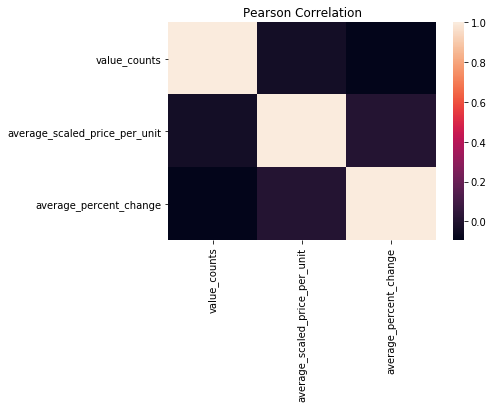

In [38]:
plt.title('Pearson Correlation')
sns.heatmap(drugs[['value_counts','average_scaled_price_per_unit', 'average_percent_change']].corr())

Unfortunately, there is not much intercorrelation between any of our features of interest. The average percent change is very slightly correlated with the price per unit when we group by drugs, implying that more expensive drugs tend to receive higher percent increases. The average percent change appears to be nearly perfectly uncorrelated with the value counts, this implies that the value counts have nothing to do with what percent changes are applied to the drug prices.

### Forecasting

#### Individual Drugs

__By NDC Description__

In [39]:
#Find most frequently changed ndc prices
top_n_drug_name = raw['drug_name'].value_counts().sort_values(ascending = False)[:25]

### Forecasting

#### Market Volatility

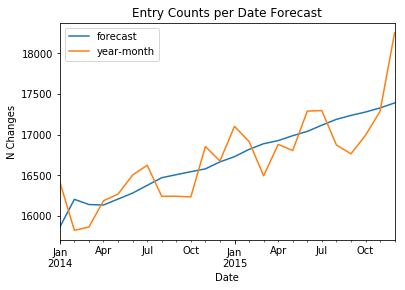

<class 'str'>
2014-01


In [40]:
#Now we will forecast the next two years of monthly entry counts
#We have already trained the model on the training set, and now we can validate it on the test set.

#count_arima_fit.predict()
size = int(len(mnth_count) * TRAIN_SPLIT)
test =  mnth_count[size:len(mnth_count)]

mnth_count.sort_index()
#Create prediction array


#Create array of timestamps:

#plt.plot(mnth_count, color = 'blue')

count_arima_fit.plot_predict(start = mnth_count.index[1], end = max(mnth_count.index))
plt.title('Entry Counts per Date Forecast')
#plt.xticks(np.arange(0,len(mnth_count.index), round((len(mnth_count.index)) / 8)), rotation = 70)
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('N Changes')
plt.show()

print(type(mnth_count.index[1]))
print(mnth_count.index[1])



In [41]:
my_date = mnth_count.index[2]
print(my_date, type(my_date))

print(min(mnth_count.index))
print(mnth_count.index)
print(mnth_count.shape)
print(type(min(mnth_count.index)))
#print(type(datetime.timestamp(min(mnth_count.index))))

print(min(mnth_count.index), type(min(mnth_count.index)))

#count_arima_fit.plot_predict(start = mnth_count.index[1],end = mnth_count.index[-1])

print(mnth_count.index[-1])
#print(type(datetime.strptime(mnth_count.index[-1], '%Y-%m')))

2014-02 <class 'str'>
2013-12
Index(['2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05',
       '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11',
       '2014-12', '2015-01', '2015-02', '2015-03', '2015-04', '2015-05',
       '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11',
       '2015-12'],
      dtype='object')
(25,)
<class 'str'>
2013-12 <class 'str'>
2015-12


#### Individual Drug Names

Rather than attempting to create and explore a model for every one of the 2350 unique drug names available in the dataset, we will instead be looking at the the top 25 most often changed drugs. The sampling methodology we use here is biased; however, we may be able to do some inferrence between this and the trends in drug prices we have seen before.

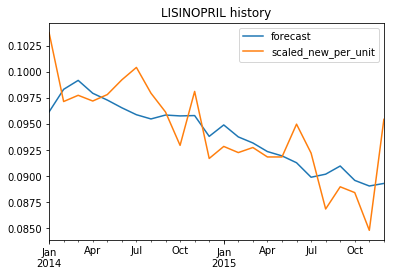

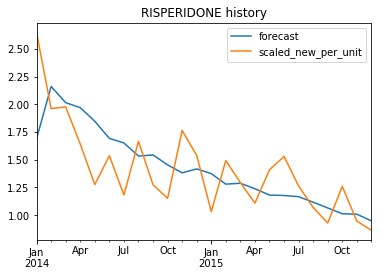

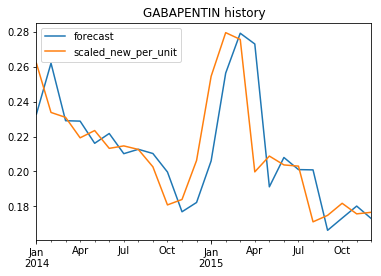

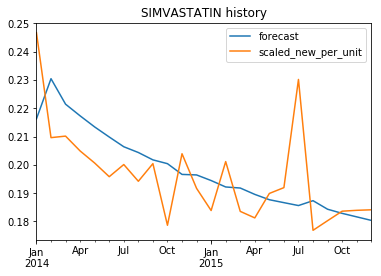

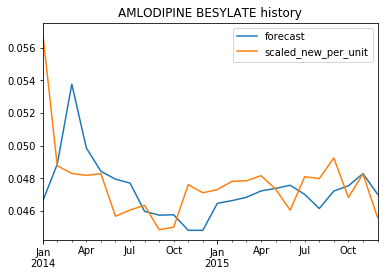

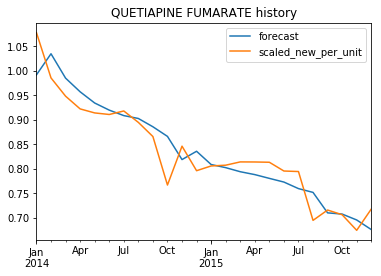

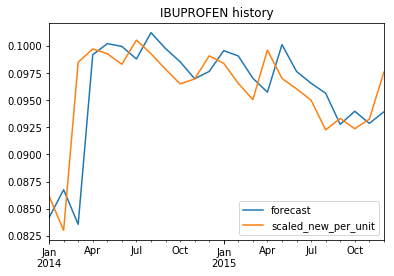

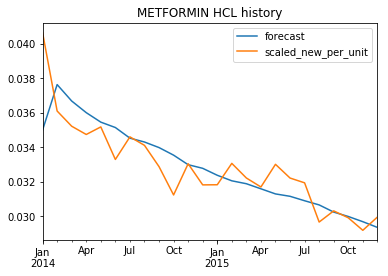

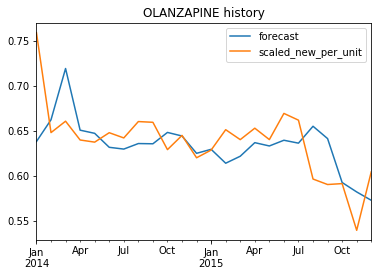

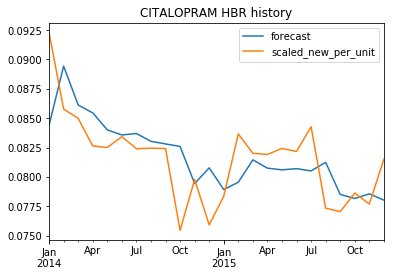

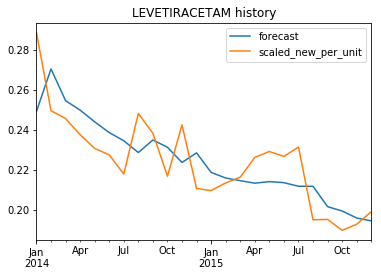

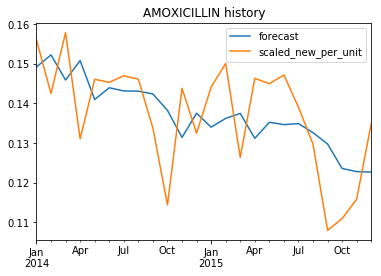

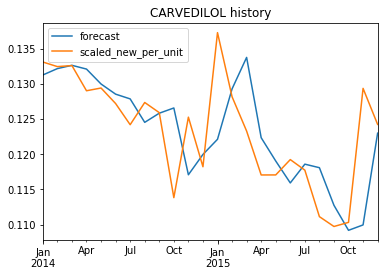

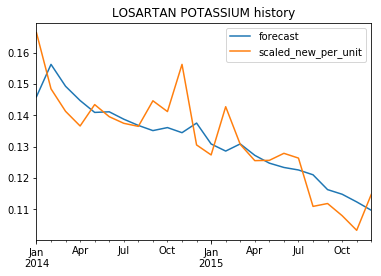

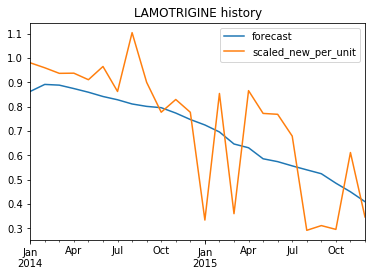

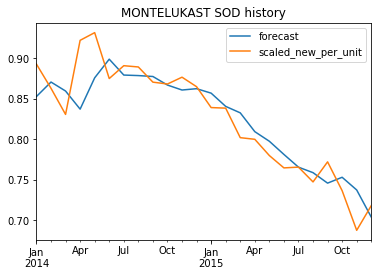

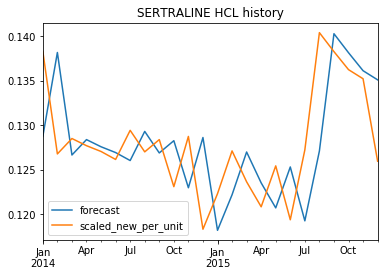

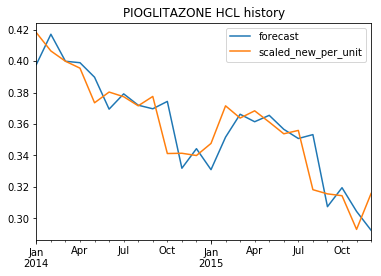

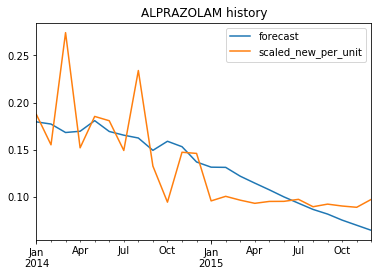

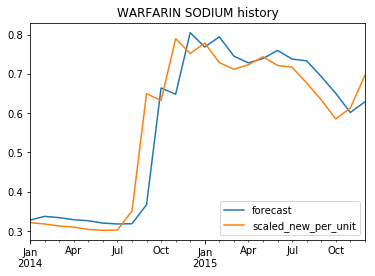

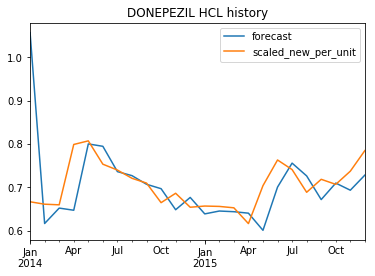

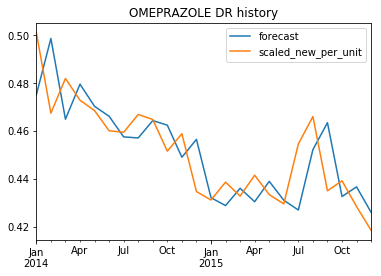

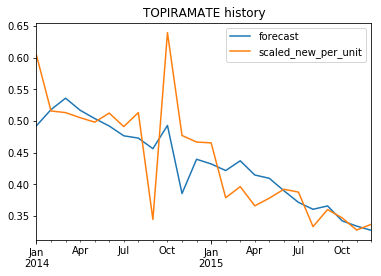

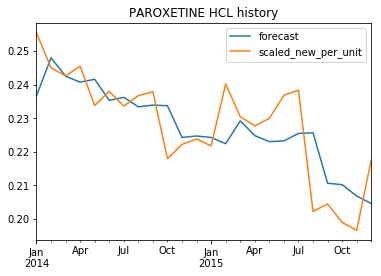

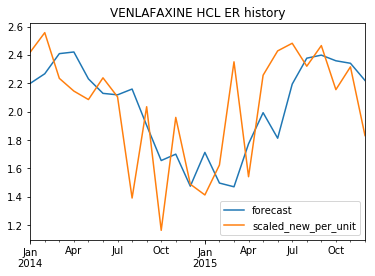

In [55]:
#Create dictionary to store models.
arima_models = {}
res_mean, res_std = [], []
res_std = []
p_value = []

ar, ma, p_val = [], [], []
#LISINOPRIL

for i, drug in enumerate(top_n_drug_name.index):
    drug_history = raw[raw['drug_name'] == str(drug)].groupby(['year-month']).mean()
    try:
        arima_models[drug] = ARIMA(drug_history['scaled_new_per_unit'], order = (1,1,1)).fit()
    #Fall through for non-stationarity
    except:
        arima_models[drug] = ARIMA(drug_history['scaled_new_per_unit'], order = (0,1,1)).fit()
    
    #Append results
    res_mean.append(arima_models[drug].resid.describe()['mean'])
    res_std.append(arima_models[drug].resid.describe()['std'])
    
    #Plot results
    arima_models[drug].plot_predict(start = drug_history.index[1],end = max(drug_history.index))
    plt.title('{} history'.format(drug))
    plt.show()

An interesting trend we can see amongst the top 25 highest change count drugs is that most of these have a general downward trend. I would hypothesize that this is a result of such drugs being sold under generic labels, being sold with more dosages and more manufacturers having manufacturing rights for these drugs, thus increasing the number of ndc labels that refer to these particular drug names.

For example, ibuprofen is a common pain relief and anti-inflamitory over the counter drug widely available in almost every grocery store. There are many different generic label brands that manufacture ibuprofen. Exploring the relationship between availability, usage, and demand for drugs would be an interesting and fruitful extension to this analysis, provided such data could be found.

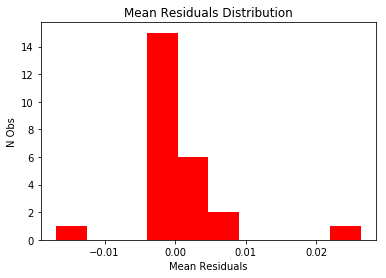

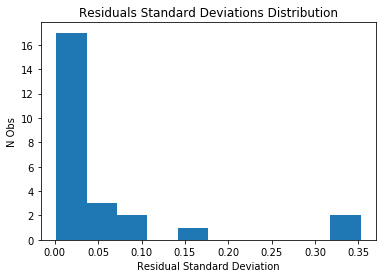

count    24.000000
mean     -0.000002
std       0.003795
min      -0.003743
25%      -0.001946
50%      -0.001367
75%       0.000769
max       0.014949
dtype: float64
<class 'pandas.core.series.Series'>


In [59]:
plt.hist(res_mean, color = 'red')
plt.title('Mean Residuals Distribution')
plt.xlabel('Mean Residuals')
plt.ylabel('N Obs')
plt.show()

plt.hist(res_std)
plt.title('Residuals Standard Deviations Distribution')
plt.xlabel('Residual Standard Deviation')
plt.ylabel('N Obs')
plt.show()

#Check the average percent change between drug at beginning and end of time frame
print(arima_models['IBUPROFEN'].resid.describe())
print(type(arima_models['IBUPROFEN'].resid.describe()))

As we can see by the distribution of residuals and our standard deviation, our models tend to perform decently. TMost drug models have a mean residual between -0.1 and 0.1 with a standard deviation between 0 and 0.1, This means that our models are capable of being fairly accurate and consistent in predicting drug prices given the low mean and standard deviation. 

Obviously, every drug acts in a slightly different way, when we roll our model over other drugs, it is always wise to validate our models, quantify error and adjust our methods as needed.

## Conclusion

In this project, we were able to pull out drug and dosage information from a string and scale price to the dosage within each drug group. We then looked at the distribution of percent change, price per unit and price change, as well as their relationship to time. The correlation matrix between these three variables and the day count revealed some interesting general trends in the marketplace.

At its most general level, we can see that drug prices are undergoing exponential growth; however, the growth itself is slowing. We came to this conclusion by observing a strong correlation between days count and drug price, and a negative correlation between percent change and days count. For every month, on average drugs are increasing by some percent,

We were able to explore a metric for market volatility and create a servicable model for forecasting purposes. As well as create a dictionary of models for the top 25 most common drug name entries.

## Further Work

I would have liked to encorporate a measure of the effects of major medical administration policy changes using A/B testing. With the current discourse surrounding the US healthcare system, it would be interesting to see what policy changes have had what effects on drug prices. We could get a more comprehensive picture of healthcare changes by encorporating other datasets from other sections of the industry, such as hospital billing and procedures. As well as encorporating data from other countries for comparison.

As mentioned before, when looking at a purly economic standpoint, we could get a more comprehensive picture of drug performances by looking at some metrics for drug supply and demand. What we have been using only has given us a single facet of the marketplace.

Finally, if we could find a comprehensive database which lists all the use cases and the effects of the drugs we have gone over, we could perform some insightful clustering that could tell us how similar and different drugs perform on the marketplace.